In [ ]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, filter_messages, ToolMessage
from langchain.chat_models import init_chat_model

import operator
from typing import Annotated, Literal, List
from pydantic import BaseModel, Field

from sys import path

path.append("../src/")
from prompts import compress_research_system_prompt, research_agent_prompt, compress_research_human_message
from tools.others import get_today_str
from tools.search import tavily_search
from tools.think import think_tool


# graph state
class ResearcherState(MessagesState):
    number_of_tool_calls: int
    research_topic: str
    research_summary: str
    raw_notes: Annotated[List[str], operator.add]


# structured output schemas
class ResearchSummary(BaseModel):
    summary: str = Field(description="Concise sumary of the webpage content")


# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model="gpt-4o-mini", temperature=0)
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="gpt-4o-mini", max_tokens=16384)
compress_model = init_chat_model(model="gpt-4o-mini") # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000


def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["messages"]
            )
        ]
    }

def summarize_research(state: ResearcherState):
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "research_summary": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }


def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"messages": tool_outputs}


def route_research(state: ResearcherState) -> Literal["tool_node", "summarize_research"]:

    messages = state["messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        path = "tool_node"
    elif len(messages) > 6:
        path = "summarize_research"
    else:
        path = "summarize_research"
    
    return path


graph = StateGraph(ResearcherState)

graph.add_node("llm_call", llm_call)
graph.add_node("tool_node", tool_node)
graph.add_node("summarize_research", summarize_research)

graph.add_edge(START, "llm_call")
graph.add_conditional_edges("llm_call", route_research, {"tool_node": "tool_node", "summarize_research": "summarize_research"})
graph.add_edge("tool_node", "llm_call")
graph.add_edge("summarize_research", END)



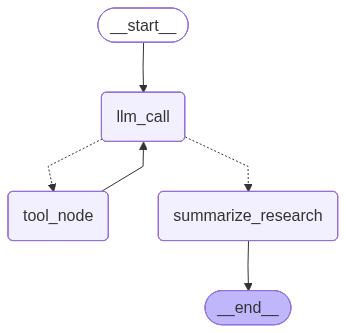

In [8]:
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
app = graph.compile(checkpointer=checkpointer)
from IPython.display import Image, display

# Show the agent
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

config = {"configurable": {"thread_id": "scoping-session-1"}}
result = app.invoke(
    {"messages": [
        HumanMessage(content=f"{research_brief}.")
    ]},
    config=config
)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops San Francisco coffee quality reviews 2025"                                        │
│ }                                                                                                               │
│    ID: call_iJeU1LKpOqOrZ56zTNOYJCWq                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Best Coffee San Francisco, CA - Last Updated November 2025 - Yelp ---                             │
│ URL: https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA                               │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ best coffee Near San Francisco, California · 1. Q Specialty Coffee. 4.6 (45 reviews). 2.0 mi. 3490 California   │
│ St, Ste A San Francisco, CA 94118. (415) 757-0536.                                                              │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Best Coffee Cafe in San Francisco 2025 | Top 10 Local Picks ---                                   │
│ URL: https://www.foodaholix.com/blogs/best-coffee-cafe-san-francisco-2025/                                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ In 2025, Foodaholix presents the top 10 coffee cafes in San Francisco, highlighting the vibrant café culture.   │
│ The list features popular spots including Saint Frank Coffee known for its ethically sourced beans, Pinhole     │
│ Coffee celebrated for its community engagement, and Andytown Coffee Roasters famous for their signature Snowy   │
│ Plover drink. Each café offers unique atmospheres and specialty beverages, perfect for both locals and          │
│ visitors. Cafés like Wrecking Ball and Sightglass also stand out for their quality and distinct designs, while  │
│ many provide family-friendly environments and options for dietary needs. The exploration of San Francisco's     │
│ coffee scene is encouraged as each café reflects the city's cultural diversity and creative spirit.             │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ San Francisco’s coffee cafes are known for their focus on quality, community, and creativity. Most of these     │
│ coffee cafes offer comfortable seating, free Wi-Fi, and a welcoming atmosphere for working or studying. For a   │
│ unique experience, try Andytown’s Snowy Plover, Sightglass’s affogato bar, or Wrecking Ball’s specialty drinks. │
│ </key_excerpts>                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found several sources that provide insights into the best coffee shops in San Francisco      │
│ based on coffee quality. The Yelp source lists top-rated coffee shops, while Foodaholix offers a curated list   │
│ of the top 10 coffee cafes, emphasizing their unique offerings and quality. The Per Diem app provides detailed  │
│ reviews and highlights specific coffee flavors and experiences. However, I need to assess the coffee quality    │
│ more deeply, possibly looking for expert reviews or certifications. I should conduct another search focusing on │
│ expert reviews or coffee quality assessments from reputable organizations."                                     │
│ }                                                                                                               │
│    ID: call_tMSxrHHaFpx1oDuB7Fm9r6Uq                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found several sources that provide insights into the best coffee shops in San Francisco  │
│ based on coffee quality. The Yelp source lists top-rated coffee shops, while Foodaholix offers a curated list   │
│ of the top 10 coffee cafes, emphasizing their unique offerings and quality. The Per Diem app provides detailed  │
│ reviews and highlights specific coffee flavors and experiences. However, I need to assess the coffee quality    │
│ more deeply, possibly looking for expert reviews or certifications. I should conduct another search focusing on │
│ expert reviews or coffee quality assessments from reputable organizations.                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "coffee quality reviews San Francisco coffee shops expert opinions 2025"                             │
│ }                                                                                                               │
│    ID: call_Isc0qjBulpgM7GdLkMVtofi6                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: The Best Coffee in the Bay Area - San Francisco Chronicle ---                                     │
│ URL: https://www.sfchronicle.com/projects/2024/best-coffee-san-francisco-bay-area/                              │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The San Francisco Bay Area is renowned for its vibrant coffee culture, featuring a diverse range of coffee      │
│ shops that offer unique experiences and flavors. In 2025, coffee shops across the region have proliferated,     │
│ showcasing cultural influences from various backgrounds including Yemeni, Indonesian, Latino, and Asian         │
│ flavors. Noteworthy shops include Ain’t Normal Cafe in Oakland, known for its extensive selection of beans and  │
│ coffee nerd culture, and Academic Coffee in San Jose, offering creative drinks like pandan lattes. Other        │
│ popular spots feature innovative concepts like the Bay Area's first coffee omakase at Komakase and trendy       │
│ pop-ups such as Hi NRG and Paper Son Coffee. The region's coffee scene represents a dynamic fusion of tradition │
│ and modern approaches to brewing, embodying the spirit of the Bay Area's coffee enthusiasts.                    │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Coffee lands in bright yellow mug at Ain’t Normal Cafe in Oakland. No other coffee hub in the nation has a      │
│ relationship as deep, or historic, as the Bay Area. This year has shown remarkable growth for the sector, with  │
│ coffee popups bringing fresh perspectives and new formats. Now is the greatest time to drink coffee in the Bay  │
│ Area.                                                                                                           │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: The Absolute Best San Francisco Coffee Shops - Eater SF ---                                       │
│ URL: https://sf.eater.com/maps/best-coffee-shops-san-francisco                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                              

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The second round of searches yielded valuable insights into coffee quality in San Francisco.   │
│ The San Francisco Chronicle highlighted the vibrant coffee culture and innovative shops, while Eater SF         │
│ provided a list of notable coffee shops with a focus on quality. Coffee Review offered specific ratings and     │
│ tasting notes for various coffees, which is crucial for assessing coffee quality. I now have a mix of expert    │
│ opinions, customer reviews, and specific coffee ratings. I should compile this information to create a          │
│ well-supported list of top coffee shops based on coffee quality."                                               │
│ }                                                                                                               │
│    ID: call_CPLfxv7iJyV7mwMNC7ORnHpt                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The second round of searches yielded valuable insights into coffee quality in San          │
│ Francisco. The San Francisco Chronicle highlighted the vibrant coffee culture and innovative shops, while Eater │
│ SF provided a list of notable coffee shops with a focus on quality. Coffee Review offered specific ratings and  │
│ tasting notes for various coffees, which is crucial for assessing coffee quality. I now have a mix of expert    │
│ opinions, customer reviews, and specific coffee ratings. I should compile this information to create a          │
│ well-supported list of top coffee shops based on coffee quality.                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the research conducted, here is a well-supported list of the top coffee shops in San Francisco,        │
│ emphasizing their coffee quality as of 2025:                                                                    │
│                                                                                                                 │
│ 1. **Saint Frank Coffee**                                                                                       │
│    - **Overview**: Known for its ethically sourced beans and commitment to quality, Saint Frank Coffee has      │
│ become a staple in the San Francisco coffee scene.                                                              │
│    - **Expert Opinion**: Recognized for its unique offerings and quality, it has expanded its presence in the   │
│ city.                                                                                                           │
│    - **Customer Feedback**: Highly rated for its smooth and flavorful brews.                                    │
│                                                                                                                 │
│ 2. **Wrecking Ball Coffee**                                                                                     │
│    - **Overview**: This shop is celebrated for its innovative approach to coffee, coining the term 'waves of    │
│ coffee' to describe its brewing methods.                                                                        │
│    - **Expert Opinion**: Featured prominently in Eater SF for its quality and unique drink offerings.           │
│    - **Customer Feedback**: Patrons appreciate the rich flavors and the café's vibrant atmosphere.              │
│                                                                                                                 │
│ 3. **Q Specialty Coffee**                                                                                       │
│    - **Overview**: A newcomer that has quickly gained recognition for its meticulous brewing techniques and     │
│ high-quality beans.                                                                                             │
│    - **Expert Opinion**: Highlighted in both Eater SF and Foodaholix for its exceptional coffee quality.        │
│    - **Customer Feedback**: Customers rave about the distinct flavors and the knowledgeable staff.              │
│                                                                                                                 │
│ 4. **Hedge Coffee Roasters**                                                                                    │
│    - **Overview**: Known for its methodical approach to coffee roasting and brewing, Hedge Coffee Roasters has  │
│ made a name for itself in the specialty coffee community.                                                       │
│    - **Expert Opinion**: Praised for its quality and innovative offerings.                                      │
│    - **Customer Feedback**: Regulars enjoy the unique flavor profiles and the café's welcoming environment.     │
│                                                                                                                 │
│ 5. **Andytown Coffee Roasters**                                                                                 │
│    - **Overview**: Famous for its signature drink, the Snowy Plover, Andytown focuses on high-quality, locally  │
│ sourced beans.                                                                                                  │
│    - **Expert Opinion**: Recognized for its community engagement and quality coffee.                            │
│    - **Customer Feedback**: Customers love the unique drinks and the cozy atmosphere.                           │
│                                                        